In [9]:
%matplotlib inline 

# standard libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Topic Modeling with BERT
#### Leveraging BERT and TF-IDF to create easily interpretable topics.

See https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6 for a great tutorial (code in this notebook comes from the tutorial)

In [65]:
from hbn.models.topic_modeling import *

# load data
# dataframe contains sentences for all HBN clinical questionnaires

#data_dir = '/Users/maedbhking/Documents/healthy_brain_network/data/raw/phenotype'
data_dir = '/Users/maedbhking/Documents/hbn_data'
fname = 'item-names-cleaned.csv'

df = pd.read_csv(os.path.join(data_dir, fname))

# get sentences to be input to topic modeling routine
data = df['questions'].dropna().tolist()
idx = df['questions'].isna()
df_dict = df[~idx].reset_index(drop=True)

# save directory
save_dir = '/Users/maedbhking/Downloads/'

## Quick fix changes to domain names in data dictionary
* one of the domain names for Parent Measures is missing in https://docs.google.com/spreadsheets/d/1sGb3ECGR47BzIWNZwzh4ARrjFaf5ByVA/edit#gid=1593310919
* therefore, we are assigning all measures corresponding to this missing domain as `Symptoms`

In [86]:
## quick fix to missing Parent domain names ##
measures_to_change = ['SympChck', 'ICU_P', 'ARI_P', 'SRS_Pre', 'SRS', 'RBS', 'SDQ', 'WHODAS_P', 'SAS', 
                'CIS_P', 'SCQ', 'ASSQ', 'SWAN','ESWAN','SCARED_P','MFQ_P', 'CBCL', 'CBCL_Pre']
for abbrev in df_dict['datadic'].unique():
    if abbrev in measures_to_change:
        df_dict.loc[df_dict["datadic"]==abbrev, "domains"] = 'Symptoms'

In [87]:
## quick fix to make domain names more palatable for visualization ##

remap = {'Questionnaire_Measures_of_Family_Structure_Stress_and_Trauma': 'Trauma',
        'Demographic_Questionnaire_Measures': 'Demographics',
        'Questionnaire_Measures_of_Emotional_and_Cognitive_Status': 'Emotional Status',
        'Physical_Fitness_and_Status': 'Fitness',
        'Language_Tasks': 'Language',
        'Vision': 'Vision',
        'Medical_Status_Measures': 'Medical History',
        'Neurologic_Function': 'MRI/EEG',
        'Questionnaire_Measures_of_Substance_Use_&_Addiction': 'Substance Use',
        'Cognitive_Testing': 'Cognition',
        'Interview_of_Emotional_and_Psychological_Function': 'Psychological Function',
        'Motor_Skills': 'Motor Skills',
        'Physiologic_Function': 'Physiology',
         'Questionnaire_Measures_of_Family_structure_Stress_and_Trauma': 'Trauma',
         'Questionnaire_Measures_of_Family_structure_Stress_and_Trauma': 'Trauma',
         'Symptoms': 'Symptoms'
        }

for domain in df_dict['domains'].unique():
    if domain in remap.keys():
        df_dict.loc[df_dict['domains']==domain, 'domains'] = remap[domain]

## Embeddings

The very first step we have to do is converting the documents to numerical data. We use BERT for this purpose as it extracts different embeddings based on the context of the word. Not only that, there are many pre-trained models available ready to be used.

How you generate the BERT embeddings for a document is up to you. However, I prefer to use the `sentence-transformers` package as the resulting embeddings have shown to be of high quality and typically work quite well for document-level embeddings.

We are using Distilbert as it gives a nice balance between speed and performance. The package has several multi-lingual models available for you to use.

NOTE: Since transformer models have a token limit, you might run into some errors when inputting large documents. In that case, you could consider splitting documents into paragraphs.

In [10]:
# get embeddings
embeddings = get_embeddings(data, transformer='all-MiniLM-L6-v2') # 'distilbert-base-nli-mean-tokens'

Batches: 


## Clustering

We want to make sure that documents with similar topics are clustered together such that we can find the topics within these clusters. Before doing so, we first need to lower the dimensionality of the embeddings as many clustering algorithms handle high dimensionality poorly.

### UMAP
Out of the few dimensionality reduction algorithms, UMAP is arguably the best performing as it keeps a significant portion of the high-dimensional local structure in lower dimensionality.

We use the package `umap-learn` before we lower the dimensionality of the document embeddings. We reduce the dimensionality to 5 while keeping the size of the local neighborhood at 15. You can play around with these values to optimize for your topic creation. Note that a too low dimensionality results in a loss of information while a too high dimensionality results in poorer clustering results.

In [14]:
# get umap embeddings
umap_embeddings = dimensionality_reduction(embeddings)

### HDBSCAN
After having reduced the dimensionality of the documents embeddings to 5, we can cluster the documents with the `hdbscan` package. HDBSCAN is a density-based algorithm that works quite well with UMAP since UMAP maintains a lot of local structure even in lower-dimensional space. Moreover, HDBSCAN does not force data points to clusters as it considers them outliers.

In [16]:
# get clusters
cluster = clustering(umap_embeddings, min_cluster_size=30)

Great! We now have clustered similar documents together which should represent the topics that they consist of. To visualize the resulting clusters we can further reduce the dimensionality to 2 and visualize the outliers as grey points:

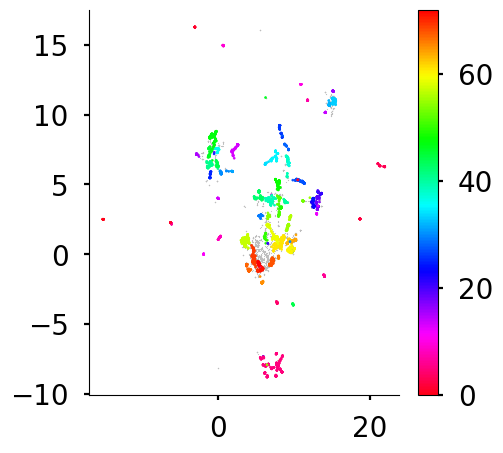

In [8]:
plotting_style()

# visualize clusters
visualize_clusters(embeddings, cluster, n_neighbors=18)

It is difficult to visualize the individual clusters due to the number of topics generated. However, we can see that even in 2-dimensional space some local structure is kept.

NOTE: You could skip the dimensionality reduction step if you use a clustering algorithm that can handle high dimensionality like a cosine-based k-Means.

## Topic Creation

What we want to know from the clusters that we generated, is what makes one cluster, based on their content, different from another?

How can we derive topics from clustered documents?

To solve this, I came up with a class-based variant of TF-IDF (c-TF-IDF), that would allow me to extract what makes each set of documents unique compared to the other.

The intuition behind the method is as follows. When you apply TF-IDF as usual on a set of documents, what you are basically doing is comparing the importance of words between documents.

What if, we instead treat all documents in a single category (e.g., a cluster) as a single document and then apply TF-IDF? The result would be a very long document per category and the resulting TF-IDF score would demonstrate the important words in a topic.

### c-TF-IDF
To create this class-based TF-IDF score, we need to first create a single document for each cluster of documents:

In [17]:
# get docs_per_topic
docs_per_topic, docs_df = tf_idf(data, cluster)


Then, we apply the class-based TF-IDF by joining documents within a class.
Where the frequency of each word t is extracted for each class i and divided by the total number of words w. This action can be seen as a form of regularization of frequent words in the class. Next, the total, unjoined, number of documents m is divided by the total frequency of word t across all classes n.

In [18]:
# get idf scores
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))


Now, we have a single importance value for each word in a cluster which can be used to create the topic. If we take the top 10 most important words in each cluster, then we would get a good representation of a cluster, and thereby a topic.

In order to create a topic representation, we take the top 20 words per topic based on their c-TF-IDF scores. The higher the score, the more representative it should be of its topic as the score is a proxy of information density.

In [22]:
# create topic representation
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); 


We can use topic_sizes to view how frequent certain topics are:

In [23]:
print(topic_sizes.head(10))

    Topic  Size
0      -1  1657
32     31   628
28     27   565
8       7   410
4       3   373
2       1   288
19     18   272
29     28   179
23     22   125
22     21   125


The topic name-1 refers to all documents that did not have any topics assigned. The great thing about HDBSCAN is that not all documents are forced towards a certain cluster. If no cluster could be found, then it is simply an outlier.

We can see that topics 28,6,43 are the largest clusters that we could create. To view the words belonging to those topics, we can simply use the dictionarytop_n_words to access these topics:

In [25]:
print(top_n_words[31][:10])

print(top_n_words[27][:10])

print(top_n_words[7][:10])

print(top_n_words[3][:10])

[('things', 0.0862682976462244), ('feel', 0.08435807822147219), ('child', 0.07423354046553221), ('like', 0.06242128403786072), ('parents', 0.044392939938107785), ('good', 0.04133627509739949), ('13', 0.03904192731635455), ('24', 0.03891393971868429), ('doesn', 0.03798413559491877), ('feels', 0.03735696995223034)]
[('present', 0.12999980510224504), ('past', 0.12608711896443808), ('disorder', 0.10278627721582516), ('anxiety', 0.06155820503786946), ('impairment', 0.05758179299453508), ('social', 0.04811324387675382), ('functioning', 0.041142530249142245), ('bipolar', 0.038325607755628176), ('situations', 0.03648978750342547), ('does', 0.032784702774910614)]
[('substance', 0.32148461212799484), ('use', 0.28452449668881225), ('present', 0.17097692008433846), ('past', 0.16407736051408972), ('desire', 0.08587046025816118), ('role', 0.08325060380603617), ('reduce', 0.08143335544668695), ('sedatives', 0.06819103575144812), ('drugs', 0.06450519937402617), ('stimulants', 0.06371186892564645)]
[('

Looking at the largest four topics, I would say that these nicely seem to represent easily interpretable topics!


## Visualization

Put everything together and visualize the clusters + their corresponding topic

In [108]:
# create topic data to figure out which topics are assigned to each sentence 
docs_topic = docs_df.merge(topic_sizes, on=['Topic'])
topic_data = pd.concat([df_dict, docs_topic], axis=1)

df_all = visualize_clusters_interactive(embeddings=embeddings, 
                                        topic_data=topic_data,
                                        hover_data=['measures', 'questions', 'domains', 'Topic'], # 'Topic', 'datadic',
                                        cluster=cluster, 
                                        n_neighbors=20,
                                        min_dist=0.8,
                                        n_components=2
                                       )

## How are measures assigned to topics/clusters?

In [23]:
measures = df_all['datadic'].unique()

df_concat = pd.DataFrame()
for metric in ['labels', 'Topic']:
    count_all = []
    for measure in measures:
        count = df_all[(df_all['datadic']==measure) & (df_all['labels']!=-1) & (df_all['Topic']!=-1)][metric].unique()
        count_all.append(len(count))

    df = pd.DataFrame({'count': np.array(count_all),
                        'measures': measures,
                        'metric': np.tile(metric, len(count_all))})

    df_concat = pd.concat([df_concat, df])

metric='labels'
print(f'assigning measures to {metric} \n')
print('the following measures are considered outliers and are not assigned to clusters: \n')
print(df_concat[df_concat['count']==0]['measures'].unique())

print('\n')
      
print('the following measures are assigned to many clusters (most - least): \n')
tmp = df_concat[
    (df_concat['metric']==metric) & (df_concat['count']!=0)].sort_values(
    by='count', ascending=False)['measures'].head(10).tolist()
print(tmp)

assigning measures to labels 

the following measures are considered outliers and are not assigned to clusters: 

['ACE' 'ACE_P' 'APQ_P' 'APQ_SR' 'ARI_P' 'ARI_S' 'ASR' 'ASSQ' 'AUDIT'
 'Barratt' 'BasicDemo' 'BIA' 'C3SR' 'CAARS' 'CBCL' 'CBCL_Pre' 'CCSC'
 'CELF' 'CELF_Full_9to21' 'CELF_Full_5to8' 'CELF_Meta' 'CFS' 'CGAS'
 'CIS_P' 'CIS_SR' 'ColorVision' 'ConsensusD' 'CPIC' 'CSSRS' 'CTOPP'
 'DailyMed' 'PhenX_Neighborhood']


the following measures are assigned to many clusters (most - least): 

['PreInt_DevH', 'PreInt_FamH', 'SympChck', 'YSR', 'PreInt_EduH', 'PMHS', 'PBQ', 'PAQ_A', 'PreInt_TxH', 'PreInt_FamHx_RDC']


## Topic Reduction

There is a chance that, depending on the dataset, you will get hundreds of topics that were created! You can tweak the parameters of HDBSCAN such that you will get fewer topics through its min_cluster_size parameter but it does not allow you to specify the exact number of clusters.

A nifty trick that Top2Vec was using is the ability to reduce the number of topics by merging the topic vectors that were most similar to each other.

We can use a similar technique by comparing the c-TF-IDF vectors among topics, merge the most similar ones, and finally re-calculate the c-TF-IDF vectors to update the representation of our topics:

In [79]:
# topic reduction

docs_df_adj, top_n_words_adj = topic_reduction(data, docs_df, tf_idf)
topic_sizes_adj = extract_topic_sizes(docs_df_adj);

Above, we took the least common topic and merged it with the most similar topic. By repeating this 19 more times we reduced the number of topics from 56 to 36!

NOTE: We can skip the re-calculation part of this pipeline to speed up the topic reduction step. However, it is more accurate to re-calculate the c-TF-IDF vectors as that would better represent the newly generated content of the topics. You can play around with this by, for example, update every n steps to both speed-up the process and still have good topic representations.

TIP: You can use the method described in this article (or simply use BERTopic) to also create sentence-level embeddings. The main advantage of this is the possibility to view the distribution of topics within a single document.

In [28]:
print(top_n_words[31][:10])

print(top_n_words[2][:10])

print(top_n_words[29][:10])

print(top_n_words[31][:10])

[('things', 0.0862682976462244), ('feel', 0.08435807822147219), ('child', 0.07423354046553221), ('like', 0.06242128403786072), ('parents', 0.044392939938107785), ('good', 0.04133627509739949), ('13', 0.03904192731635455), ('24', 0.03891393971868429), ('doesn', 0.03798413559491877), ('feels', 0.03735696995223034)]
[('language', 1.2795789567278075), ('setting', 0.5169695939957689), ('spoken', 0.49143568223969364), ('life', 0.4631705581759184), ('parent', 0.401884980458612), ('relative', 0.3317745728055885), ('child', 0.23676245602386536), ('sibling', 0.18936428970003366), ('english', 0.09493193691939111), ('foreign', 0.09493193691939111)]
[('parents', 0.7332890260341071), ('argue', 0.5292049789300942), ('arguments', 0.22913688068832216), ('usually', 0.19934906528408455), ('argument', 0.16226100893016654), ('disagree', 0.13877847534793739), ('disagreement', 0.11450939826763443), ('don', 0.11304083325323128), ('arguing', 0.10576540158114345), ('blame', 0.08326708520876243)]
[('things', 0.0

## Topic Modeling with BERTopic

Code taken from this tutorial: https://python.plainenglish.io/topic-modeling-for-beginners-using-bertopic-and-python-aaf1b421afeb. Github here: https://github.com/MaartenGr/BERTopic

In [120]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer, util
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=20, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,    # Step 1 - Extract embeddings
  umap_model=umap_model,              # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words
#   n_gram_range=(1, 2),
  nr_topics=30,
  min_topic_size=15,                   
  calculate_probabilities=True,        
  verbose=True
)

topics, probs = topic_model.fit_transform(data)
topic_model.get_topic_info()

Batches: 
2023-05-04 19:59:48,245 - BERTopic - Transformed documents to Embeddings
2023-05-04 19:59:50,746 - BERTopic - Reduced dimensionality
2023-05-04 19:59:51,756 - BERTopic - Clustered reduced embeddings
2023-05-04 19:59:53,917 - BERTopic - Reduced number of topics from 92 to 30


,Topic,Count,Name
0,-1,1694,-1_use_past_child_things
1,0,1292,0_use_child_present_substance
2,1,515,1_30_days_age_things
3,2,391,2_score_percentile_raw_rank
4,3,281,3_disorder_anxiety_diagnosis_psychiatric
5,4,266,4_language_age_mother_father
6,5,214,5_history_disease_cause_sibling
7,6,187,6_stage_dominant_treadmill_participant
8,7,164,7_eating_eat_food_foods
9,8,150,8_used_medication_occasions_planned


## Visualize Topics

In [121]:
 
topic_model.visualize_topics()

## Visualizing word frequency

In [122]:
topic_model.visualize_barchart(top_n_topics=10)

## Visualize topic similarity

In [123]:
# topic_model.update_topics(data, n_gram_range=(1, 2))
# topic_model.reduce_topics(data, nr_topics=3)
topic_model.visualize_heatmap(n_clusters=5, width=1000, height=1000)

## Find topics

In [126]:
topic_model.find_topics("anxiety")


([3, 12, 5, 17, 24],
 [0.7340845678576906,
  0.5495153620142735,
  0.5120333552897665,
  0.4634958667443072,
  0.46214157187839805])

## Visualize hierarchy

In [125]:
topic_model.visualize_hierarchy()

## Check out this other tutorial using Top2Vec
https://github.com/ddangelov/Top2Vec

## Sentence similarity across measures

Code taken from here: https://www.sbert.net/docs/usage/semantic_textual_similarity.html

## Paraphrase Mining

In [53]:
from sentence_transformers import SentenceTransformer, util

# https://www.sbert.net/examples/applications/paraphrase-mining/README.html

model = SentenceTransformer('all-MiniLM-L6-v2')

paraphrases = util.paraphrase_mining(model, data, show_progress_bar=True)

for paraphrase in paraphrases[0:1]:
    score, i, j = paraphrase
    print("{} \t\t {} \t\t Score: {:.4f}".format(data[i], data[j], score))
    
df_paraphrases = pd.DataFrame(paraphrases, columns=['score', 'idx1', 'idx2'])

## Compare all pairwise combinations of clinical questionnaires

This takes some time so I've run it on openmind: 
```
sbatch /om2/user/maedbh/healthy_brain_network/hpc_scripts/run_item_analysis.sh
```


dendrogram clustering: https://www.python-graph-gallery.com/404-dendrogram-with-heat-map (https://www.python-graph-gallery.com/)

In [70]:
# load sentence similarity
#data_dir = '/Users/maedbhking/Documents/healthy_brain_network/data/interim/subtypes'
data_dir = '/Users/maedbhking/Documents/hbn_data'
fname = 'sentence-similarity_HBN_mean_scores-all-MiniLM-L6-v2.csv'

df = pd.read_csv(os.path.join(data_dir, fname))

## Generate heatmap of similarity between clinical questionnaires



In [90]:
# get measures
measures = df['idx1'].unique()

# get domains
domains = []
for abbrev in df_dict['datadic'].unique():
    domain_name = df_dict[df_dict['datadic']==abbrev]['domains'].unique()[0]
    domains.append(domain_name)
domains = np.array(domains)

# get assessments
assessments = []
for abbrev in df_dict['datadic'].unique():
    assessment_name = df_dict[df_dict['datadic']==abbrev]['assessment'].unique()[0]
    assessments.append(assessment_name)
assessments = np.array(assessments)
assessments = [f[0] for f in assessments] # abbrev name

tensor = np.ones((len(measures), len(measures)))
for i, idx1 in enumerate(measures):
    for ii, idx2 in enumerate(measures):
        
        # get score
        score = df[(df['idx1']==idx1) & (df['idx2']==idx2)]['mean_score']
        
        if score.shape[0]==0:
            score = df[(df['idx1']==idx2) & (df['idx2']==idx1)]['mean_score']
        
        tensor[i,ii] = score;

tensor_df = pd.DataFrame(tensor, columns=assessments)

tensor_df['new_col'] = assessments
tensor_df = tensor_df.set_index('new_col')

# drop rows and columsn that contain NaN
tensor_df = tensor_df.drop(['n'], axis=0).drop(['n'], axis=1)

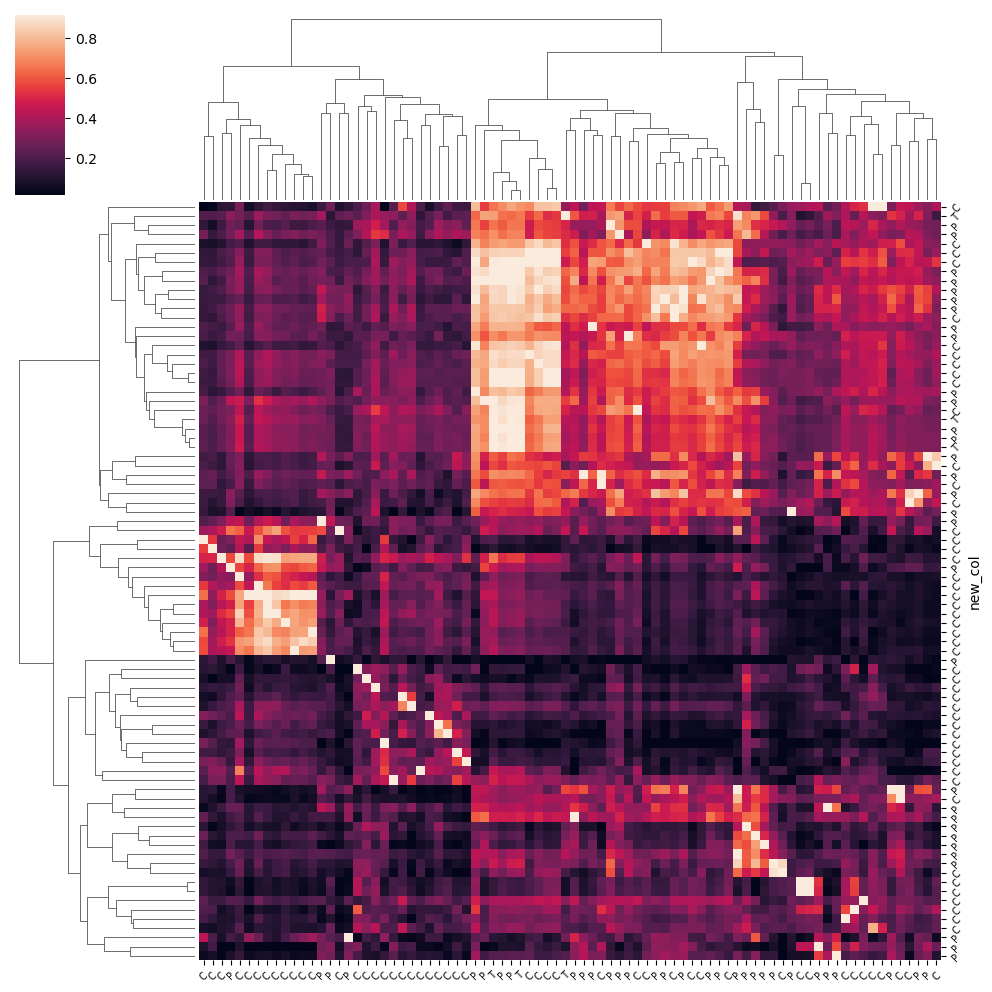

In [104]:
g = sns.clustermap(tensor_df, 
               standard_scale=1, 
               metric="euclidean", 
               robust=True, 
               row_cluster=True,
               #method="ward",
               #center=1,
               yticklabels=True, 
               xticklabels=True,
              ); #method="ward"

g.ax_heatmap.yaxis.set_ticks_position("right")

plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), fontsize=7, rotation=45)
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=7, rotation=45)
plt.savefig(os.path.join(save_dir, 'All_Measures_heatmap-assessment.png'))
plt.show()


## Take the diagonal

Majority of measures are about .4 correlated in terms of their semantic similarity (e.g., YSR-YSR)

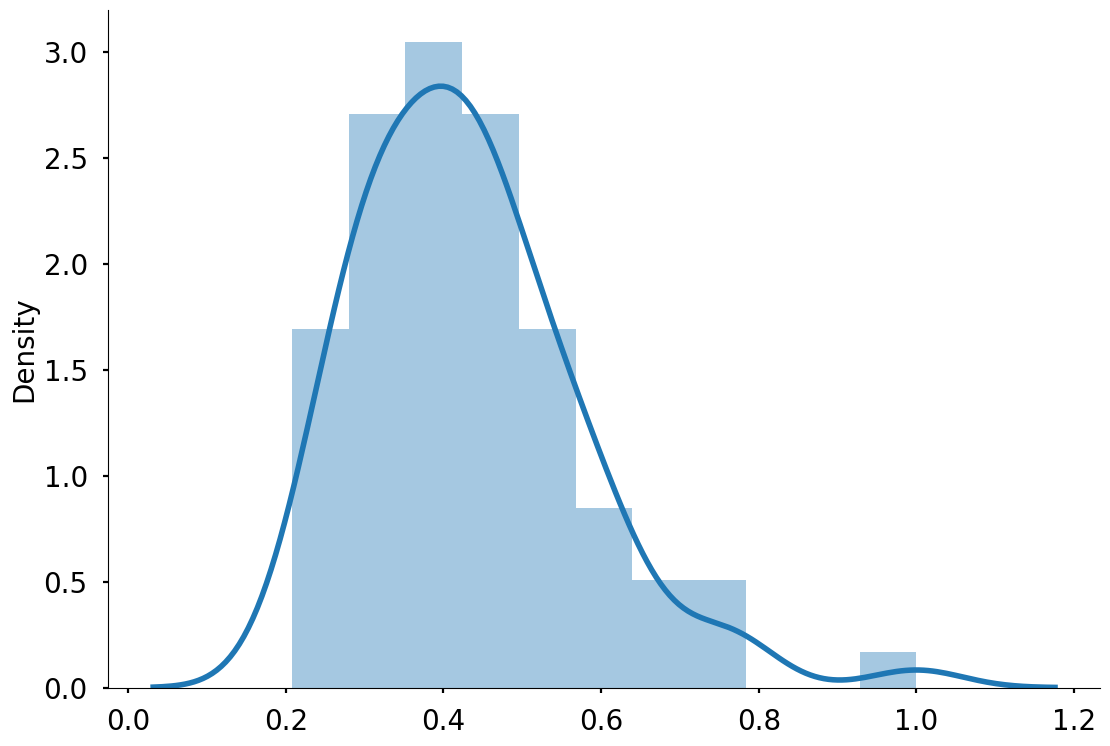

In [106]:
plotting_style()
sns.distplot(np.diagonal(np.array(tensor_df)))
plt.savefig(os.path.join(save_dir, 'All_measures_diagonal.png'))

## Cluster heatmap based on Parent, Child, Teacher assessment

In [93]:
# get tensors

def get_tensor_subset(
    df,
    df_dict,
    measures,
    domains,
    assessment='Child Measures',
    labels='domains'
    ):

    bool_all = []
    for measure in measures:
        # check assessment
        check = df_dict[df_dict['datadic']==measure]['assessment'].unique()

        if check==assessment:
            idx = True
        else:
            idx = False
        bool_all.append(idx)

    # get measures
    measures_subset = measures[bool_all]
    domains_subset = domains[bool_all]
    
    tensor = np.ones((len(measures_subset), len(measures_subset)))
    for i, idx1 in enumerate(measures_subset):
        for ii, idx2 in enumerate(measures_subset):

            # get score
            score = df[(df['idx1']==idx1) & (df['idx2']==idx2)]['mean_score']

            if score.shape[0]==0:
                score = df[(df['idx1']==idx2) & (df['idx2']==idx1)]['mean_score']

            tensor[i,ii] = score;
    
    if labels=='domains':
        tensor_subset = pd.DataFrame(tensor, columns=domains_subset)
        tensor_subset['new_col'] = domains_subset
    elif labels=='measures':
        tensor_subset = pd.DataFrame(tensor, columns=measures_subset)
        tensor_subset['new_col'] = measures_subset
    
    tensor_subset = tensor_subset.set_index('new_col')
    
    return tensor_subset

In [102]:
# get tensor

tensor_subset = get_tensor_subset(df, df_dict, measures, domains, assessment='Child Measures', labels='measures')

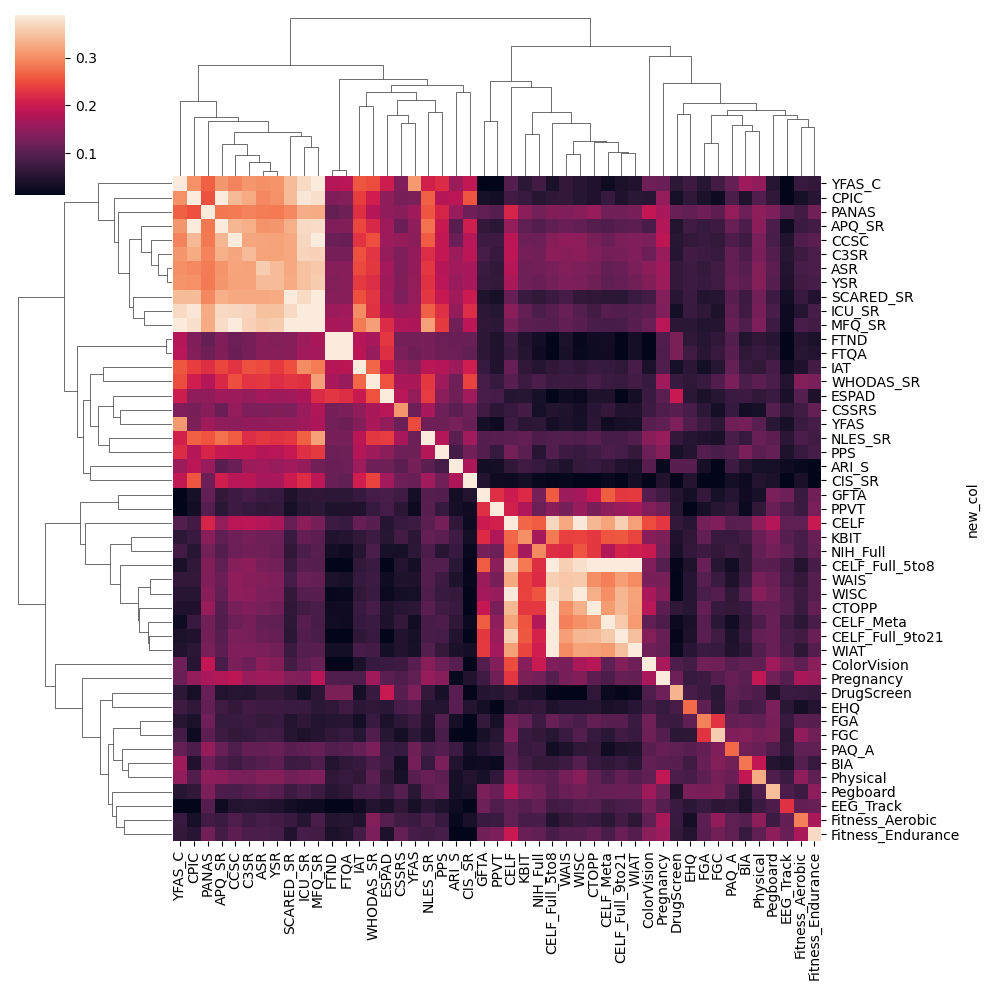

In [103]:
g = sns.clustermap(tensor_subset, 
               #standard_scale=1, 
               metric="euclidean", 
               robust=True, 
               row_cluster=True,
               #method="ward",
               #center=1,
               yticklabels=True, 
               xticklabels=True,
               #linewidths=0.004
              );


g.ax_heatmap.yaxis.set_ticks_position("right")

plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), fontsize=10)
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10)
plt.savefig(os.path.join(save_dir, 'Child_Measures_heatmap-measures.png'))
plt.show()

<Axes: ylabel='Density'>

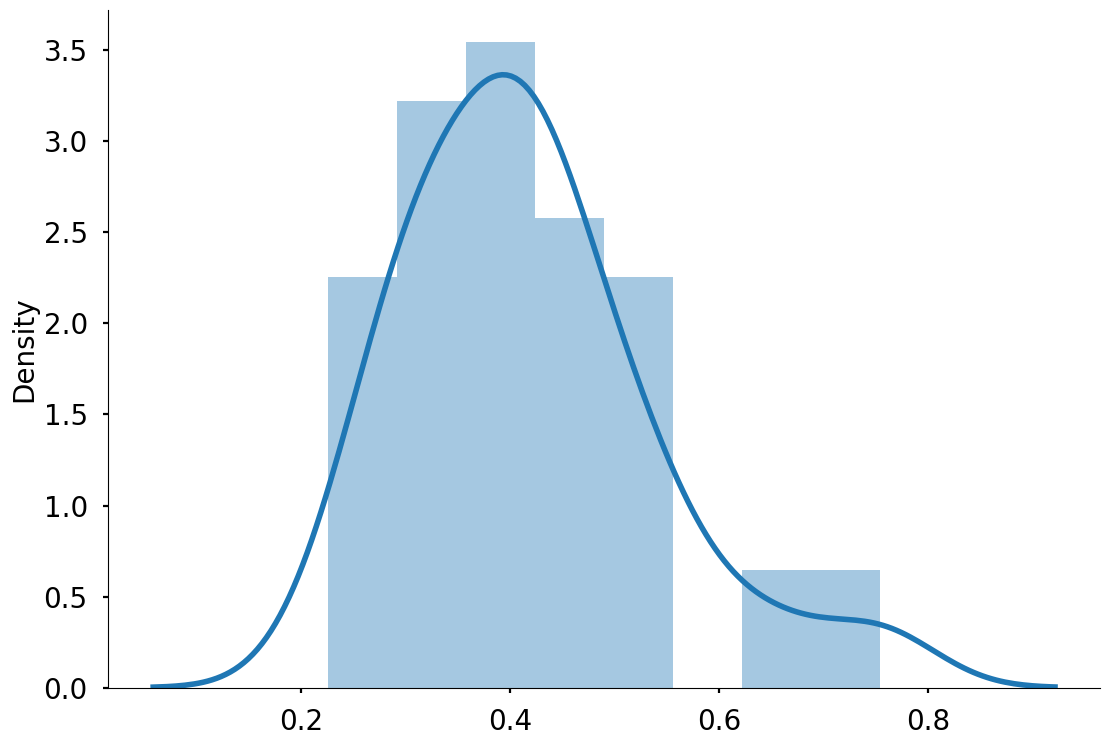

In [107]:
plotting_style()
sns.distplot(np.diagonal(np.array(tensor_subset)))

In [4]:
from hbn.models.item_analysis import sentence_similarity_single_pair

tensor_dict = sentence_similarity_single_pair(
    data_dictionary=df_dict, 
    transformer='all-MiniLM-L6-v2', 
    pairwise_measures=('YSR', 'CBCL')
    )

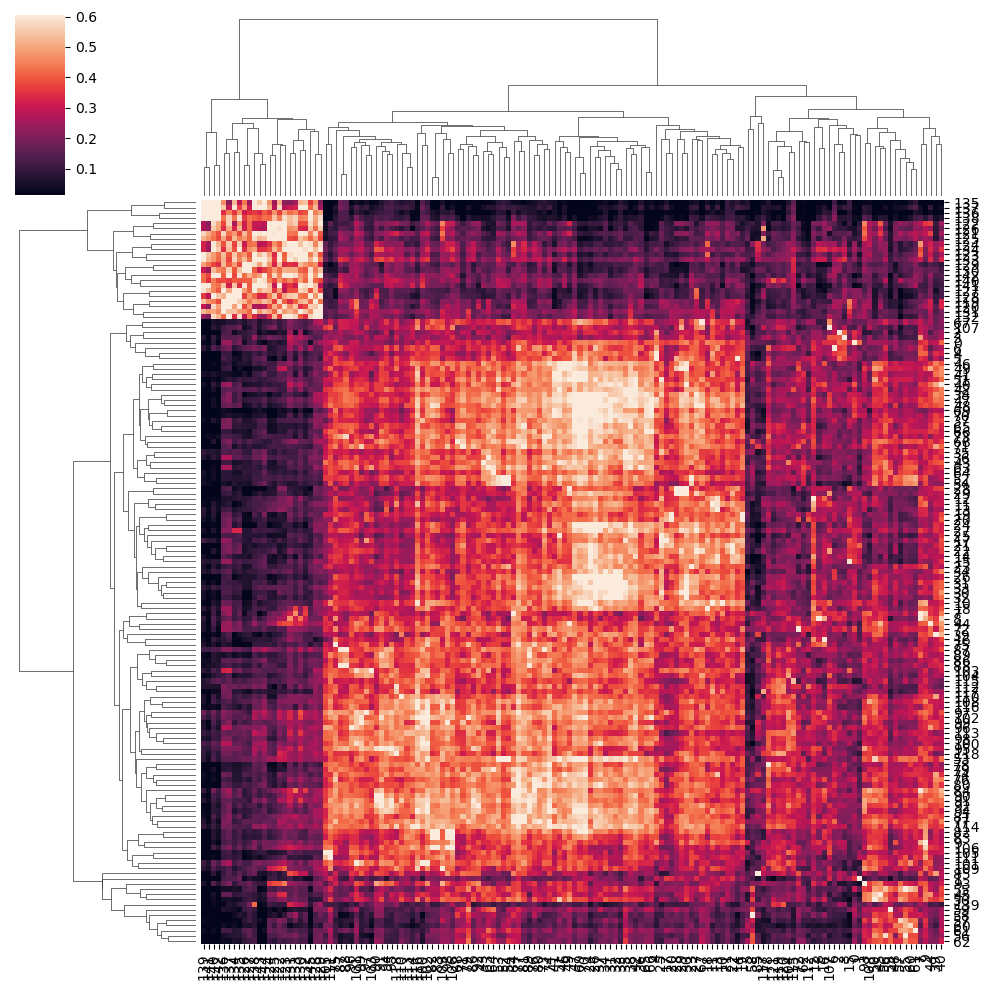

In [8]:
g = sns.clustermap(tensor_dict['cosine_scores'], 
               #standard_scale=1, 
               metric="euclidean", 
               robust=True, 
               row_cluster=True,
               #method="ward",
               #center=1,
               yticklabels=True, 
               xticklabels=True,
               #linewidths=0.004
              );


g.ax_heatmap.yaxis.set_ticks_position("right")

plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), fontsize=10)
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10)
plt.show()